In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import ConfusionMatrixDisplay, auc, confusion_matrix, roc_curve
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import matplotlib.patheffects as path_effects

In [2]:
import torch
import torchvision.models as models

def count_total_denselayer(model):
    """
    Freezes all layers of the model (sets requires_grad=False).
    """
    count = 0
    for name, _ in model.named_parameters():
        if "denselayer" in name and "conv" in name:
            count += 1
    return count
    
def freeze_up_to_last_x_layers(model, percentage_frozen_layers):
    """
    Freezes all layers in the model, but unfrozes the last `num_layers_to_unfreeze` layers of DenseBlock 4.
    
    Args:
    - model: The DenseNet121 model.
    - num_layers_to_unfreeze: The number of layers to unfreeze from the last dense block.
    """
    # Step 1: Freeze all layers in the model
    total_dense_layers = count_total_denselayer(model)
    layers_to_freeze = total_dense_layers*percentage_frozen_layers
    print(f"Total dense layer count {total_dense_layers}")
    print(f"Layers to freeze {layers_to_freeze}")
    count = 0
    for name, param in model.named_parameters():
        if count < layers_to_freeze:
            param.requires_grad = False
        if "denselayer" in name and "conv" in name:
            count += 1
    return count



In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_data_loaders(train_dir, test_dir, batch_size):
    # Define data augmentation and transformations
    train_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(25),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor()
    ])

    test_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Load datasets
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

    # Create dataloaders
    num_cores = os.cpu_count() - 1
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_cores, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_cores, pin_memory=True)

    return train_loader, test_loader


def create_model(model_type, dropout_rate, percentage_frozen_layers):
    # Load the specified pre-trained model (either DenseNet or ResNet)
    if model_type == 'resnet18':
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    elif model_type == 'resnet34':
        model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
    elif model_type == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    elif model_type == 'densenet121':
        model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
    elif model_type == 'densenet169':
        model = models.densenet169(weights=models.DenseNet169_Weights.DEFAULT)
    elif model_type == 'densenet201':
        model = models.densenet201(weights=models.DenseNet201_Weights.DEFAULT)
    else:
        raise ValueError("Invalid model type. Choose from 'resnet18', 'resnet34', 'resnet50', 'densenet121', 'densenet169', or 'densenet201'.")

    # Check the model type (ResNet or DenseNet)
    if "resnet" in model_type:
        print("Detected model: ResNet")
    else:
        print("Detected model: DenseNet")
        # Freeze layers and unfreeze the last X dense layers (e.g., last 3 layers)
        freeze_up_to_last_x_layers(model, percentage_frozen_layers)

        # for name, param in model.named_parameters():
        #     print(f"{name} requires_grad: {param.requires_grad}")
        # (model, percentage_frozen_layers)

    # Modify the final layer for binary classification
    if 'densenet' in model_type:  # DenseNet uses a different naming for the final layer
        num_ftrs = model.classifier.in_features
        if (percentage_frozen_layers == 0):
            print("# Training baseline")
            model.classifier = nn.Linear(num_ftrs, 2)
        else:
            model.classifier = nn.Sequential(
                nn.Dropout(p=dropout_rate),
                nn.Linear(num_ftrs, 512),
                nn.ReLU(),
                nn.Dropout(p=dropout_rate),
                nn.Linear(512, 2)
        )
    else:  # ResNet models
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 2)
        )

    return model.to(device)


def get_optimizer(optimizer_type, model_parameters, learning_rate, weight_decay):
    # Filter parameters where requires_grad=True
    trainable_params = filter(lambda p: p.requires_grad, model_parameters)
    
    if optimizer_type == 'adam':
        return optim.AdamW(trainable_params, lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_type == 'sgd':
        return optim.SGD(trainable_params, lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_type == 'adamax':
        return optim.Adamax(trainable_params, lr=learning_rate, weight_decay=weight_decay)
    else:
        raise ValueError("Invalid optimizer type. Choose from 'adam', 'sgd', or 'adamax'.")


def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, patience):
    """
    Train a model and return metrics such as train/test accuracies and losses.
    
    Args:
        model: The model to be trained.
        train_loader: DataLoader for the training dataset.
        test_loader: DataLoader for the test dataset.
        criterion: Loss function.
        optimizer: Optimizer.
        num_epochs: Number of epochs to train.
        patience: Number of epochs with no improvement after which training will stop.
    
    Returns:
        train_accuracies: List of training accuracies per epoch.
        test_accuracies: List of testing accuracies per epoch.
        train_losses: List of training losses per epoch.
        test_losses: List of testing losses per epoch.
    """
    best_loss = float('inf')
    epochs_no_improve = 0

    train_accuracies, test_accuracies = [], []
    train_losses, test_losses = [], []

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for the epoch
        print(f"Epoch {epoch + 1}/{num_epochs}:", end=' ')

        # Training phase
        model.train()  # Set model to training mode
        running_loss, correct_preds, total_samples = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()  # Move to GPU if available

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update metrics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_loss = running_loss / total_samples
        epoch_accuracy = correct_preds / total_samples * 100
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.cuda(), labels.cuda()

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / val_total
        val_accuracy = val_correct / val_total * 100
        test_losses.append(val_loss)
        test_accuracies.append(val_accuracy)

        # End time for the epoch
        epoch_time = time.time() - start_time  # Calculate time taken for the epoch

        # Print everything in one line
        print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, "
              f"Epoch Time: {epoch_time:.2f} seconds", end='\n')

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

    return train_accuracies, test_accuracies, train_losses, test_losses


def train_resnet(model_type, percentage_frozen_layers, train_loader, test_loader, learning_rate, weight_decay, num_epochs, patience, dropout_rate):
    print(f"Training ResNet model: {model_type} with {percentage_frozen_layers*100}% frozen layers...")

    model = create_model(model_type=model_type, percentage_frozen_layers=percentage_frozen_layers, dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer('adam', model.parameters(), learning_rate, weight_decay)

    train_accuracies, test_accuracies, train_losses, test_losses = train_model(
        model, train_loader, test_loader, criterion, optimizer, num_epochs, patience
    )

    test_accuracy, all_labels, all_preds, all_probs = evaluate_model(model, test_loader)
    
    return train_accuracies, test_accuracies, train_losses, test_losses, all_labels, all_preds, all_probs


def train_densenet(model_type, percentage_frozen_layers, train_loader, test_loader, learning_rate, weight_decay, num_epochs, patience, dropout_rate):
    print(f"Training DenseNet model: {model_type} with {percentage_frozen_layers*100} frozen layers...")

    model = create_model(model_type=model_type, percentage_frozen_layers=percentage_frozen_layers, dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer('adam', model.parameters(), learning_rate, weight_decay)

    train_accuracies, test_accuracies, train_losses, test_losses = train_model(
        model, train_loader, test_loader, criterion, optimizer, num_epochs, patience
    )

    test_accuracy, all_labels, all_preds, all_probs = evaluate_model(model, test_loader)
    
    return train_accuracies, test_accuracies, train_losses, test_losses, all_labels, all_preds, all_probs


def evaluate_model(model, test_loader):
    model.eval()
    correct_test = 0
    total_test = 0
    all_labels = []
    all_preds = []
    all_probs = []  # List to store probabilities for the positive class (class 1)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Apply softmax to get probabilities for each class
            probs = F.softmax(outputs, dim=1)  # probs[:, 1] gives probability for class 1 (positive class)
            
            # Get predicted class labels (class with the highest probability)
            _, predicted = torch.max(outputs, 1)

            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Collect probabilities for the positive class

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy, all_labels, all_preds, all_probs  # Return all_probs for ROC curve

In [4]:
def plot_metrics(train_accuracies, test_accuracies, train_losses, test_losses, all_labels, all_preds, all_probs):
    # Find the best accuracy and lowest loss points
    best_train_accuracy_epoch = np.argmax(train_accuracies)
    best_test_accuracy_epoch = np.argmax(test_accuracies)
    lowest_train_loss_epoch = np.argmin(train_losses)
    lowest_test_loss_epoch = np.argmin(test_losses)

    best_train_accuracy = train_accuracies[best_train_accuracy_epoch]
    best_test_accuracy = test_accuracies[best_test_accuracy_epoch]
    lowest_train_loss = train_losses[lowest_train_loss_epoch]
    lowest_test_loss = test_losses[lowest_test_loss_epoch]

    # Plot accuracy trends
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    accuracy_line_train, = plt.plot(train_accuracies, label="Train Accuracy")
    accuracy_line_test, = plt.plot(test_accuracies, label="Test Accuracy")
    
    plt.scatter(best_train_accuracy_epoch, best_train_accuracy, color=accuracy_line_train.get_color(), s=100, label=f"Best Train Accuracy: {best_train_accuracy:.2f}%")
    plt.scatter(best_test_accuracy_epoch, best_test_accuracy, color=accuracy_line_test.get_color(), s=100, label=f"Best Test Accuracy: {best_test_accuracy:.2f}%")
    
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Trend")
    plt.legend()

    # Plot loss trends
    plt.subplot(1, 2, 2)
    loss_line_train, = plt.plot(train_losses, label="Train Loss")
    loss_line_test, = plt.plot(test_losses, label="Test Loss")
    
    plt.scatter(lowest_train_loss_epoch, lowest_train_loss, color=loss_line_train.get_color(), s=100, label=f"Lowest Train Loss: {lowest_train_loss:.4f}")
    plt.scatter(lowest_test_loss_epoch, lowest_test_loss, color=loss_line_test.get_color(), s=100, label=f"Lowest Test Loss: {lowest_test_loss:.4f}")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Trend")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    
    # Plot confusion matrix with two titles for predicted and actual values
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap="Blues", values_format="d", ax=ax)
    
    # Example for text with black outline and white filling
    ax.text(0, 0.2, 'TN', ha='center', va='center', fontsize=12, color='white',
            path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])
    ax.text(1, 0.2, 'FP', ha='center', va='center', fontsize=12, color='white',
            path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])
    ax.text(0, 1.2, 'FN', ha='center', va='center', fontsize=12, color='white',
            path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])
    ax.text(1, 1.2, 'TP', ha='center', va='center', fontsize=12, color='white',
            path_effects=[path_effects.withStroke(linewidth=3, foreground='black')])

    plt.title("Pneumonia Diagnosis", fontsize=16)
    plt.show()

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


In [5]:
def main(batch_size, num_epochs, learning_rate, weight_decay, 
         resnet_configs, densenet_configs, dropout_rate, patience):
    
    results = []  # List to store results for each model

    # Data loading
    train_loader, test_loader = get_data_loaders('../../data/train', '../../data/test', batch_size)

    # Train ResNet models
    for model_type, percentage_frozen_layers_list in resnet_configs:
        train_accuracies, test_accuracies, train_losses, test_losses, all_labels, all_preds, all_probs = train_resnet(
            model_type, percentage_frozen_layers_list, train_loader, test_loader, learning_rate, weight_decay, num_epochs, patience, dropout_rate
        )

        results.append({
            'Model Type': model_type,
            'Frozen Layers': percentage_frozen_layers_list,
            'Best Train Accuracy (%)': max(train_accuracies),
            'Best Test Accuracy (%)': max(test_accuracies),
            'Final Train Accuracy (%)': train_accuracies[-1],
            'Final Test Accuracy (%)': test_accuracies[-1],
            'Best Train Loss': min(train_losses),
            'Best Test Loss': min(test_losses)
        })

        # Plot the metrics
        plot_metrics(train_accuracies, test_accuracies, train_losses, test_losses, all_labels, all_preds, all_probs)

    # Train DenseNet models
    for model_type, percentage_frozen_layers_list in densenet_configs:
        for percentage_frozen_layers in percentage_frozen_layers_list:
            train_accuracies, test_accuracies, train_losses, test_losses, all_labels, all_preds, all_probs = train_densenet(
                model_type, percentage_frozen_layers, train_loader, test_loader, learning_rate, weight_decay, num_epochs, patience, dropout_rate
            )

            results.append({
                'Model Type': model_type,
                'Frozen Layers': percentage_frozen_layers,
                'Best Train Accuracy (%)': max(train_accuracies),
                'Best Test Accuracy (%)': max(test_accuracies),
                'Final Train Accuracy (%)': train_accuracies[-1],
                'Final Test Accuracy (%)': test_accuracies[-1],
                'Best Train Loss': min(train_losses),
                'Best Test Loss': min(test_losses)
            })

            # Plot the metrics
            plot_metrics(train_accuracies, test_accuracies, train_losses, test_losses, all_labels, all_preds, all_probs)

    # Convert the results to a pandas DataFrame
    results_df = pd.DataFrame(results)

    # Write the results to a CSV file
    results_df.to_csv('model_comparison_results.csv', index=False)
    print("Results saved to model_comparison_results.csv")


Training DenseNet model: densenet121 with 100 frozen layers...
Detected model: DenseNet
Total dense layer count 116
Layers to freeze 116
Epoch 1/25: 

/home/radugrecu97/dtu/semesters/1/deep_learning/dtu_deep_learning/.venv/lib/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)


Train Loss: 0.5975, Train Accuracy: 71.22%, Validation Loss: 0.6331, Validation Accuracy: 62.50%, Epoch Time: 17.09 seconds
Epoch 2/25: Train Loss: 0.5196, Train Accuracy: 75.25%, Validation Loss: 0.5487, Validation Accuracy: 65.22%, Epoch Time: 18.41 seconds
Epoch 3/25: Train Loss: 0.4616, Train Accuracy: 78.18%, Validation Loss: 0.4878, Validation Accuracy: 76.92%, Epoch Time: 18.55 seconds
Epoch 4/25: Train Loss: 0.4178, Train Accuracy: 81.23%, Validation Loss: 0.4342, Validation Accuracy: 84.46%, Epoch Time: 18.31 seconds
Epoch 5/25: Train Loss: 0.3893, Train Accuracy: 82.80%, Validation Loss: 0.3996, Validation Accuracy: 85.90%, Epoch Time: 18.40 seconds
Epoch 6/25: Train Loss: 0.3628, Train Accuracy: 84.62%, Validation Loss: 0.3721, Validation Accuracy: 87.98%, Epoch Time: 18.66 seconds
Epoch 7/25: Train Loss: 0.3378, Train Accuracy: 85.39%, Validation Loss: 0.3588, Validation Accuracy: 85.90%, Epoch Time: 18.57 seconds
Epoch 8/25: Train Loss: 0.3272, Train Accuracy: 86.25%, Vali

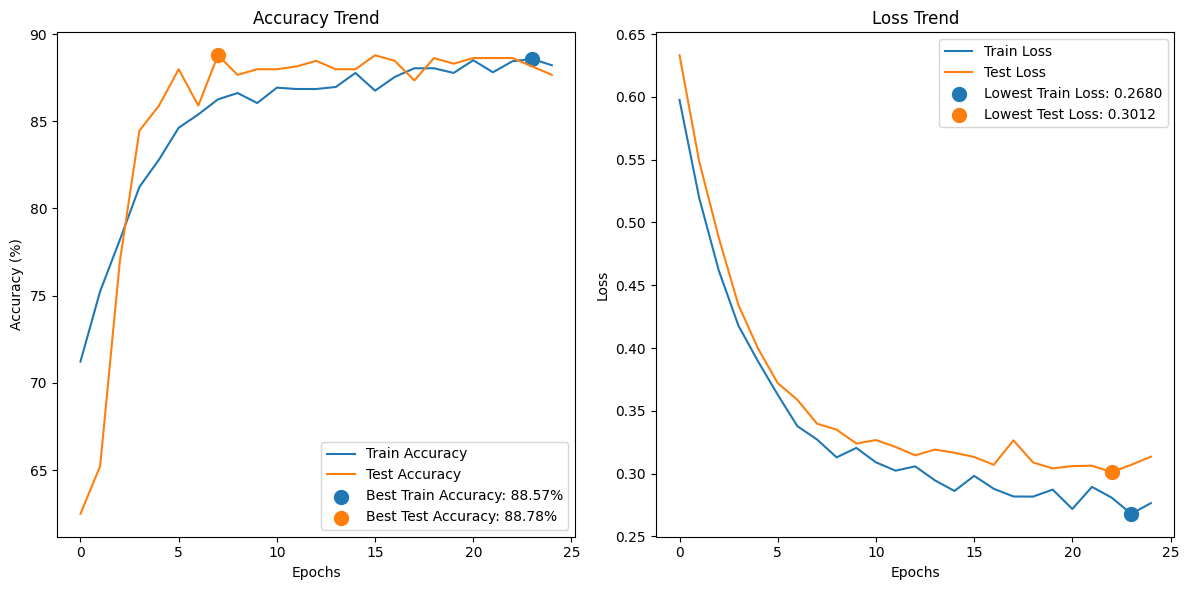

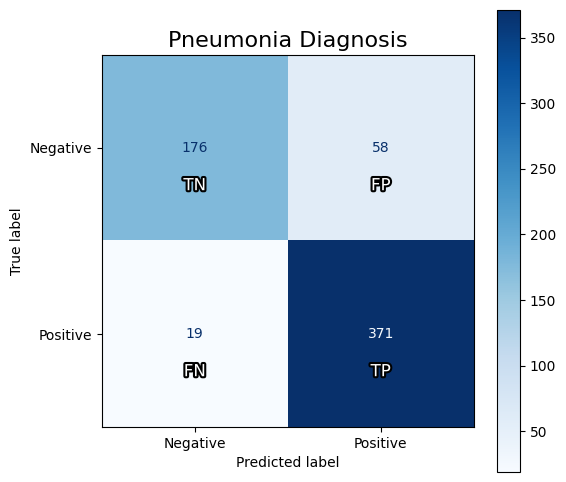

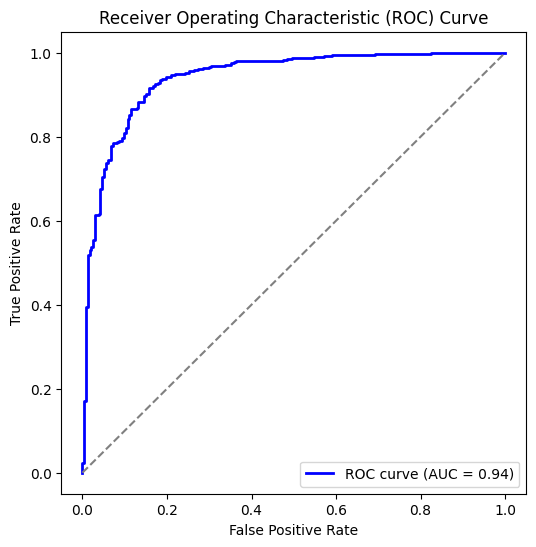

Training DenseNet model: densenet121 with 90.0 frozen layers...
Detected model: DenseNet
Total dense layer count 116
Layers to freeze 104.4
Epoch 1/25: Train Loss: 0.5822, Train Accuracy: 71.18%, Validation Loss: 0.6377, Validation Accuracy: 62.50%, Epoch Time: 18.77 seconds
Epoch 2/25: Train Loss: 0.4435, Train Accuracy: 79.41%, Validation Loss: 0.4675, Validation Accuracy: 74.84%, Epoch Time: 18.61 seconds
Epoch 3/25: Train Loss: 0.3140, Train Accuracy: 87.23%, Validation Loss: 0.3473, Validation Accuracy: 86.70%, Epoch Time: 19.05 seconds
Epoch 4/25: Train Loss: 0.2129, Train Accuracy: 92.35%, Validation Loss: 0.2881, Validation Accuracy: 89.10%, Epoch Time: 18.94 seconds
Epoch 5/25: Train Loss: 0.1773, Train Accuracy: 93.08%, Validation Loss: 0.2658, Validation Accuracy: 89.90%, Epoch Time: 19.09 seconds
Epoch 6/25: Train Loss: 0.1585, Train Accuracy: 93.98%, Validation Loss: 0.2558, Validation Accuracy: 90.38%, Epoch Time: 18.60 seconds
Epoch 7/25: Train Loss: 0.1439, Train Accura

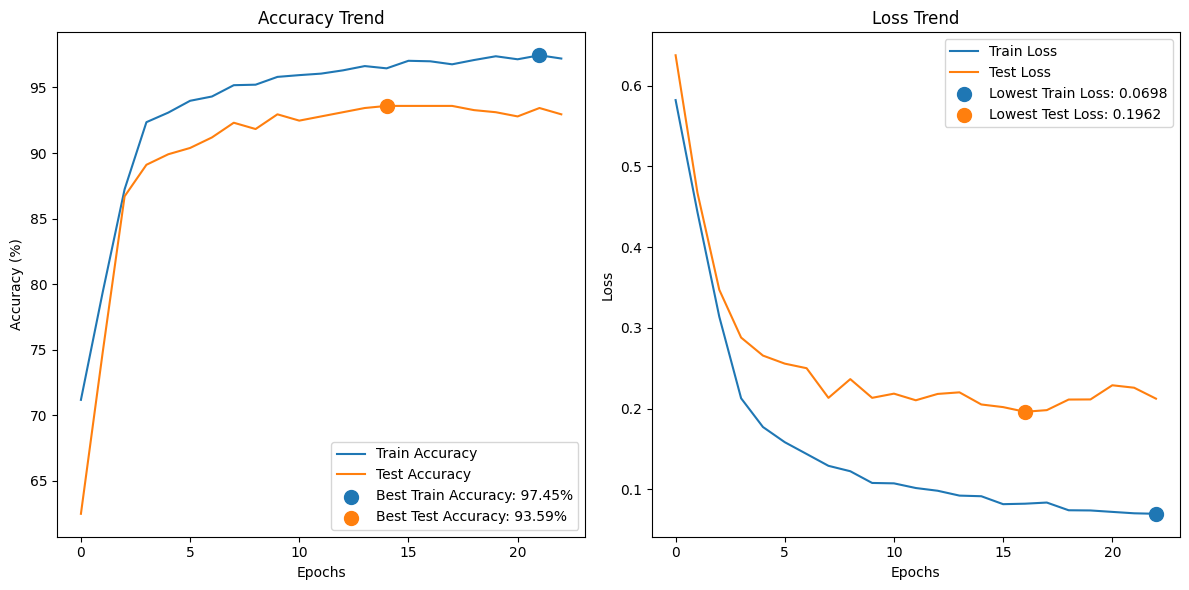

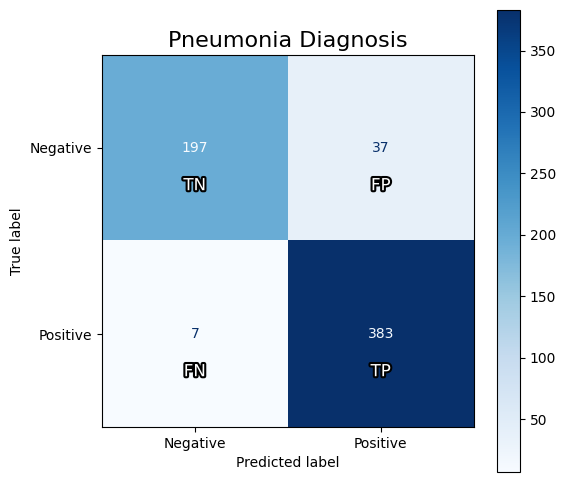

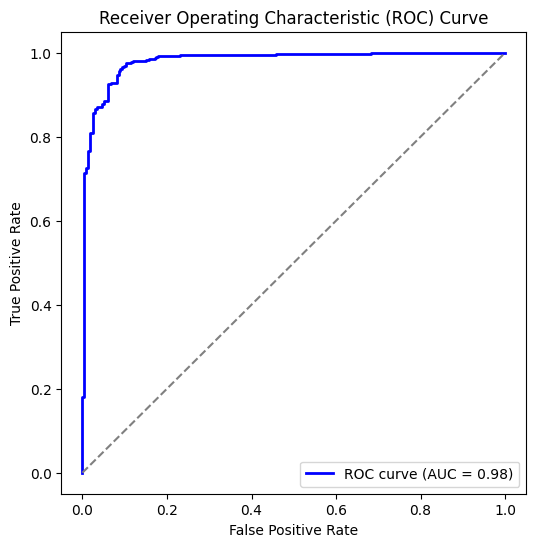

Training DenseNet model: densenet121 with 75.0 frozen layers...
Detected model: DenseNet
Total dense layer count 116
Layers to freeze 87.0
Epoch 1/25: Train Loss: 0.4967, Train Accuracy: 74.73%, Validation Loss: 0.5229, Validation Accuracy: 62.82%, Epoch Time: 19.20 seconds
Epoch 2/25: Train Loss: 0.2757, Train Accuracy: 89.76%, Validation Loss: 0.2930, Validation Accuracy: 88.94%, Epoch Time: 19.06 seconds
Epoch 3/25: Train Loss: 0.1715, Train Accuracy: 94.17%, Validation Loss: 0.2545, Validation Accuracy: 90.54%, Epoch Time: 19.20 seconds
Epoch 4/25: Train Loss: 0.1277, Train Accuracy: 95.40%, Validation Loss: 0.2430, Validation Accuracy: 90.22%, Epoch Time: 19.28 seconds
Epoch 5/25: Train Loss: 0.1164, Train Accuracy: 95.74%, Validation Loss: 0.2320, Validation Accuracy: 91.03%, Epoch Time: 19.11 seconds
Epoch 6/25: Train Loss: 0.0962, Train Accuracy: 96.64%, Validation Loss: 0.2300, Validation Accuracy: 91.67%, Epoch Time: 19.32 seconds
Epoch 7/25: Train Loss: 0.0909, Train Accurac

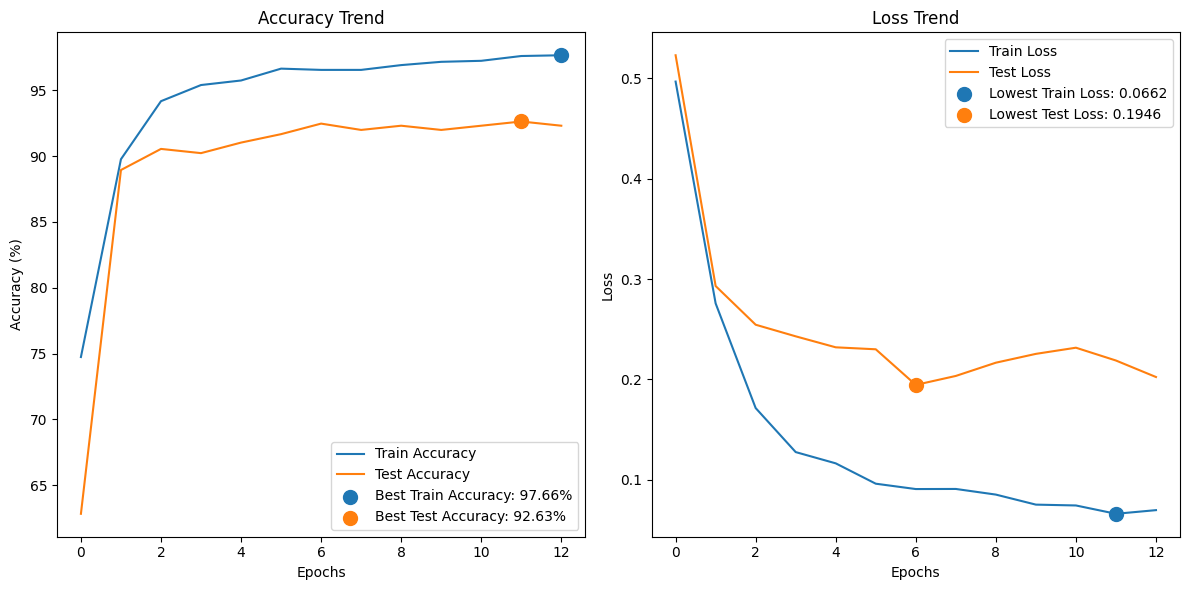

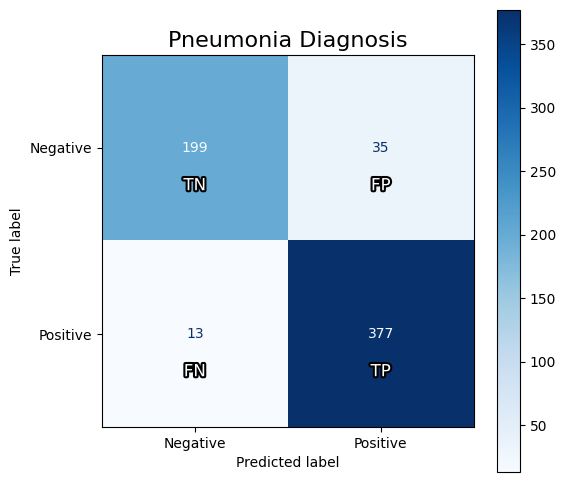

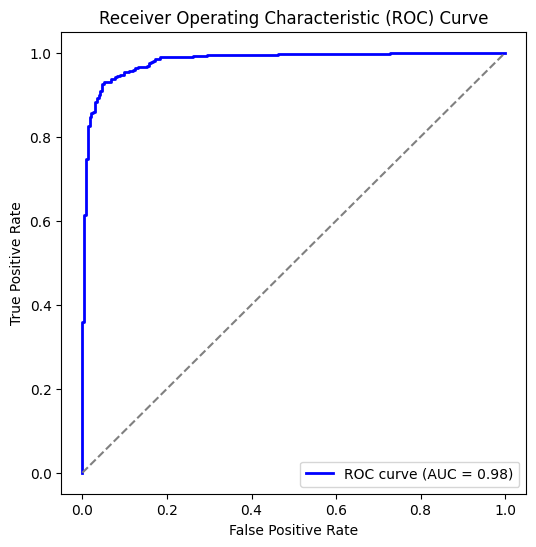

Training DenseNet model: densenet121 with 50.0 frozen layers...
Detected model: DenseNet
Total dense layer count 116
Layers to freeze 58.0
Epoch 1/25: Train Loss: 0.4290, Train Accuracy: 78.62%, Validation Loss: 0.4425, Validation Accuracy: 73.56%, Epoch Time: 19.40 seconds
Epoch 2/25: Train Loss: 0.1801, Train Accuracy: 94.88%, Validation Loss: 0.2401, Validation Accuracy: 91.51%, Epoch Time: 19.22 seconds
Epoch 3/25: Train Loss: 0.1141, Train Accuracy: 96.18%, Validation Loss: 0.2395, Validation Accuracy: 92.47%, Epoch Time: 18.42 seconds
Epoch 4/25: Train Loss: 0.0830, Train Accuracy: 97.07%, Validation Loss: 0.2348, Validation Accuracy: 92.31%, Epoch Time: 19.26 seconds
Epoch 5/25: Train Loss: 0.0670, Train Accuracy: 97.72%, Validation Loss: 0.2815, Validation Accuracy: 90.22%, Epoch Time: 19.25 seconds
Epoch 6/25: Train Loss: 0.0565, Train Accuracy: 97.99%, Validation Loss: 0.2795, Validation Accuracy: 92.15%, Epoch Time: 19.29 seconds
Epoch 7/25: Train Loss: 0.0516, Train Accurac

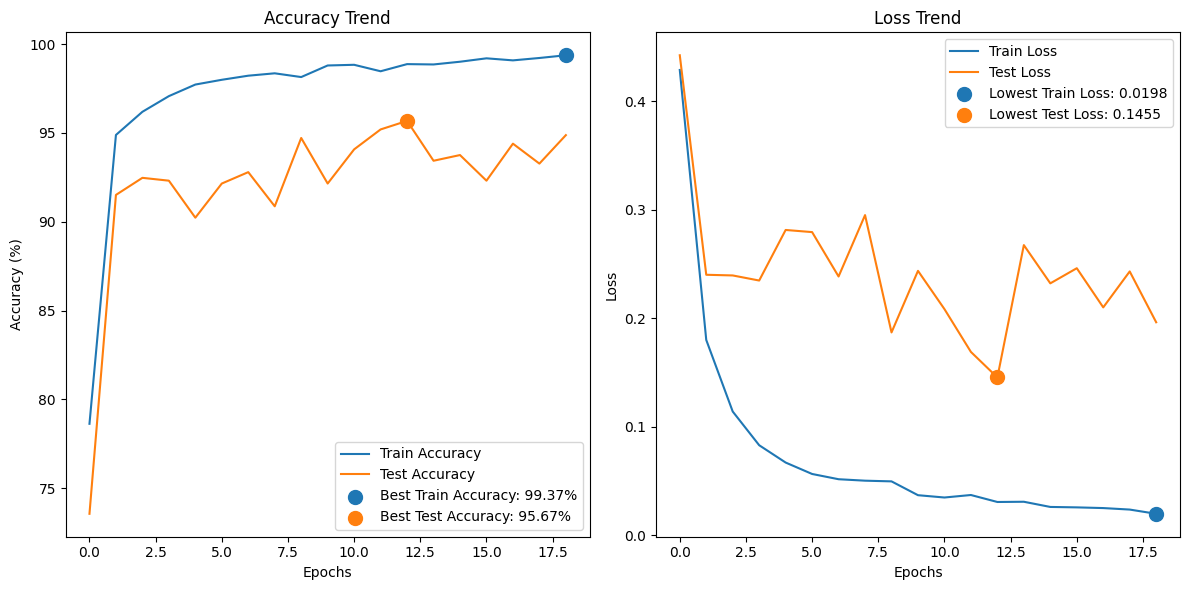

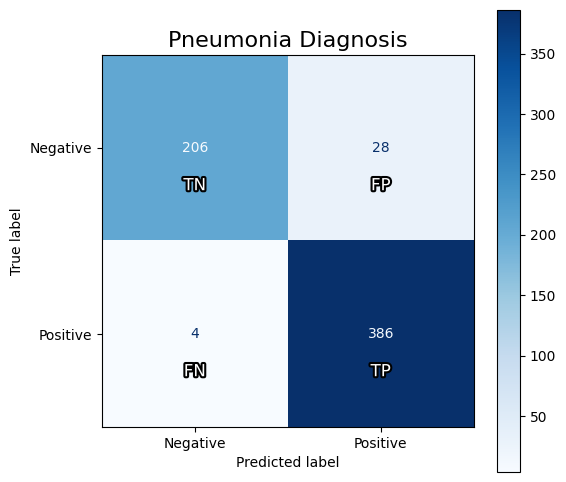

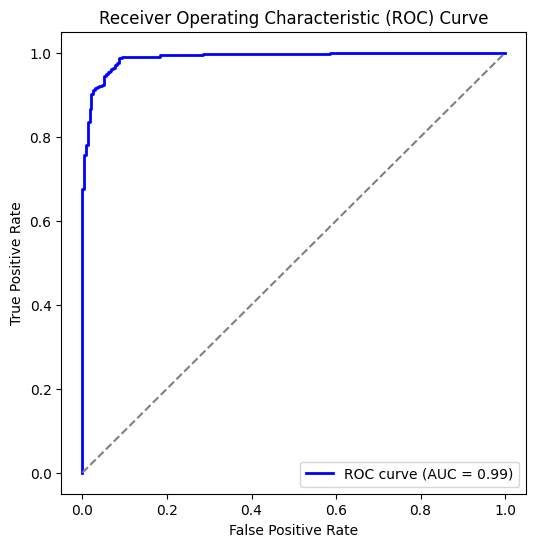

Results saved to model_comparison_results.csv


In [6]:
if __name__ == "__main__":
    resnet_configs = [
        # ('resnet18', [0, 0.25, 0.5, 0.75, 0.90]),
        # ('resnet34', 7),
        # ('resnet50', 10)
    ]

    densenet_configs = [
        ('densenet121', [1, 0.9, 0.75, 0.5]),
        # ('densenet169', 5),
        # ('densenet201', 10)
    ]


    main(batch_size=128,
         num_epochs=25,
         learning_rate=0.00005,
         weight_decay=1e-3, 
         resnet_configs=resnet_configs,
         densenet_configs=densenet_configs,
         dropout_rate=0.60,
         patience=6)


In [7]:
import gc

gc.collect()  # Call garbage collector to remove unreferenced objects
torch.cuda.empty_cache()
